# Introduction

Comme demandé par Open Classrooms, je ne livre qu'un seul Notebook. Cependant, ce notebook en contient deux :
1. Une partie qui s'exécute depuis un cluster EMR AWS, qui va récupérer des images sur S3 pour les vectoriser. Puis, on exécute une ACP dont on sauvegarde la sortie et le modèle associé, toujours dans S3.
2. Une partie dédiée à la data visualisation, qui, elle, est exécutée depuis mon IDE local que j'ai connecté à AWS S3 pour pouvoir récupérer les elements précédemment générés.

Le repository de travail est accessible [ici](https://github.com/MaximoRose/oc-ds-p08).


# -- AWS EXECUTION --

# Code existant : Spark CNN

Ce code est extrait du Notebook fournit. Il permet le traitement des images via le modèle MobileNetV2 et sauvegarde les vecteurs des images dans le bucket S3 qu'on aura nous-même configuré

In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1690814592654_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1690814592654_0001,pyspark,idle,Link,Link,✔


## 0. Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

## 1. Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [7]:
PATH = 's3://oc-ds-p8-fruits'
PATH_Data = PATH+'/input_pictures'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-ds-p8-fruits
PATH_Data:   s3://oc-ds-p8-fruits/input_pictures
PATH_Result: s3://oc-ds-p8-fruits/Results

## 3. Traitement des données

### 3.1. Chargement des données

In [11]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://oc-ds-p8-fru...|2023-07-31 14:59:40|  7353|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-31 14:59:40|  7350|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-31 14:59:40|  7349|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-31 14:59:40|  7348|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-31 14:59:40|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [13]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------+----------+
|path                                                        |label     |
+------------------------------------------------------------+----------+
|s3://oc-ds-p8-fruits/input_pictures/Watermelon/r_106_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/input_pictures/Watermelon/r_109_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/input_pictures/Watermelon/r_108_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/input_pictures/Watermelon/r_107_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/input_pictures/Watermelon/r_95_100.jpg |Watermelon|
+------------------------------------------------------------+----------+
only showing top 5 rows

None

### 3.2. Préparation du modèle

In [14]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14540800/14536120 [==============================] - 1s 0us/step

In [15]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [18]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3. Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [19]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### 3.4. Exécutions des actions d'extractions de features

In [20]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-ds-p8-fruits/Results

In [23]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# CUSTOM CODE

# ACP Spark

## 0. Chargement des fichiers

Le code initiale chargeait les fichiers parquet avec un Dataframe Pandas. Il semblait plus pertinent de directement travailler dans un environnement PySpark.

In [24]:
df_source = spark.read.parquet(PATH_Result)
df_source.select('features').show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[0.0, 0.23122607,...|
|[0.95477927, 0.05...|
|[0.11681207, 0.13...|
+--------------------+
only showing top 3 rows

In [25]:
df_source.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

On convertit le tableau de reels en VectorUDT pour pouvoir ensuite utiliser les librairies ML de PySpark

In [26]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
df = df_source.withColumn('features', ud_f('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)

## 1. Standard Scaling

In [28]:
from pyspark.ml.feature import StandardScaler

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
# Save coordinates
PATH_PCA_Result = PATH+'/PCA/outputs'
PATH_PCA_Model = PATH+'/PCA/model/pca_model'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
standardizer = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scalerModel = standardizer.fit(df)
scaled_data = scalerModel.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. PCA fit & transform

On va prendre les 10 premieres composantes principales afin de pouvoir tracer une scree plot un peu intéressante.

In [31]:
from pyspark.ml.feature import PCA

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
k=10
pca = PCA(k=k, inputCol="scaled_features") 
pca.setOutputCol("pca_features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCA_4dfb7bb4227e

In [33]:
model = pca.fit(scaled_data)
model.getK()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10

In [34]:
output_df = model.transform(scaled_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
print("Type output PCA transform : ", type(output_df))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Type output PCA transform :  <class 'pyspark.sql.dataframe.DataFrame'>

In [36]:
output_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)

In [37]:
pca_features = output_df.select('pca_features').collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
print("Collected PCA_FEATURES caracteristiques")
print("----------------------------------------------")
print("Type : ", type(pca_features))
print("Taille : ", len(pca_features))
print("Type item[0] : ", type(pca_features[0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Collected PCA_FEATURES caracteristiques
----------------------------------------------
Type :  <class 'list'>
Taille :  22688
Type item[0] :  <class 'pyspark.sql.types.Row'>

## 3. Save outputs

On va enregistrer les 10 premieres composantes principales. Puis on utilisera les deux ou trois premières pour visualiser nos images dans ce nouvel espace vectoriel.

In [39]:
pca_features[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(pca_features=DenseVector([-9.9203, 3.574, -5.2499, 0.7726, 0.2802, 10.7025, -5.6225, 10.53, 2.7056, -4.7609]))

In [40]:
def transform_list_of_vect_to_df(vectlist) :
    return pd.DataFrame([[vectlist[j][0][i] for i in range(k)] for j in range(len(vectlist))])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
transform_list_of_vect_to_df(pca_features).head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           0         1         2  ...          7         8         9
0  -9.920288  3.574020 -5.249853  ...  10.530013  2.705612 -4.760893
1 -15.101982  3.067932 -6.347238  ...  13.987329  0.747148 -5.102585

[2 rows x 10 columns]

_pca features_ ce sont les coordonnees de nos points dans notre nouveau referentiel definis par les vecteurs des composantes principales. Chaque point de donnee est exprime selon les k axes de nos CP.

In [42]:
pca_coord = transform_list_of_vect_to_df(pca_features)
pca_coord.head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           0         1         2  ...          7         8         9
0  -9.920288  3.574020 -5.249853  ...  10.530013  2.705612 -4.760893
1 -15.101982  3.067932 -6.347238  ...  13.987329  0.747148 -5.102585

[2 rows x 10 columns]

In [43]:
type(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>

In [44]:
pca_coord = pca_coord.rename(columns={0: "pc1", 1: "pc2", 2: "pc3", 3: "pc4", 4: "pc5", 5: "pc6", 6: "pc7", 7: "pc8", 8: "pc9", 9: "pc10"})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
pys_pca_coord = spark.createDataFrame(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
# Save outputs
pys_pca_coord.write.mode("overwrite").parquet(PATH_PCA_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
# Save Model
model.save(PATH_PCA_Model)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
v_explained_variance = model.explainedVariance
v_explained_variance

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DenseVector([0.0767, 0.0504, 0.0437, 0.0302, 0.0278, 0.0231, 0.0222, 0.0197, 0.0169, 0.016])

---------------------------------------------------------------------------

# -- LOCAL EXECUTION --

L'environnement PySpark AWS est peu propice à l'ajout de divers librairies nécessaires a la visualisation, sans compter que l'interface du Jupyter Hub est bien moins léchée que l'environnement PyCharm Pro que je me suis offert en debut de formation. Il m'a donc semblé plus opportun de travailler la visualisation et l'analyse des résultats depuis mon IDE habituel, en établissant une communication avec AWS S3 pour récupérer les fichiers générés précédemment.

Par ailleurs, distinguer les interfaces de recueil et de processing des données me paraissait assez cohérent avec les architectures lambda.

## 4. PCA Analysis

### 4.1. Récupération des donnees sur S3

In [1]:
import os

print("SPARK_HOME :", os.environ['SPARK_HOME'])
print("JAVA_HOME : ", os.environ['JAVA_HOME'])

SPARK_HOME : /opt/spark-3.2.4-bin-hadoop2.7
JAVA_HOME :  /opt/jdk/jdk1.8.0_202


#### Récupération des dataframes

In [2]:
import s3fs
import fastparquet as fp

def get_s3_parquet_data(parent_folder = "oc-ds-p8-fruits/PCA_outputs") :
    s3_ref = s3fs.S3FileSystem()
    fs_ref = s3fs.core.S3FileSystem()

    #mybucket/data_folder/serial_number=1/cur_date=20-12-2012/abcdsd0324324.snappy.parquet
    s3_parquet_path = parent_folder+"/*.parquet"
    all_paths_from_s3_parquet = fs_ref.glob(path=s3_parquet_path)

    open_connec = s3_ref.open
    #use s3fs as the filesystem
    fp_objet = fp.ParquetFile(all_paths_from_s3_parquet, open_with=open_connec)
    #convert to pandas dataframe
    df_output = fp_objet.to_pandas()
    return df_output

In [3]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .getOrCreate()
)

23/08/04 11:28:40 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.15 instead (on interface wlp0s20f3)
23/08/04 11:28:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/04 11:28:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/Results")
df_vectorized_images.head(2)

,path,label,features
0,s3://oc-ds-p8-fruits/input_pictures/Watermelon...,Watermelon,"[0.01771676, 0.23936023, 0.0, 0.0, 0.5658412, ..."
1,s3://oc-ds-p8-fruits/input_pictures/Pineapple ...,Pineapple Mini,"[0.0, 4.803104, 0.021533662, 0.0, 0.0, 0.0, 0...."


In [6]:
df_pca_output = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/PCA/outputs")
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585


### 4.2. Analyses visuelles

#### Scree Plot

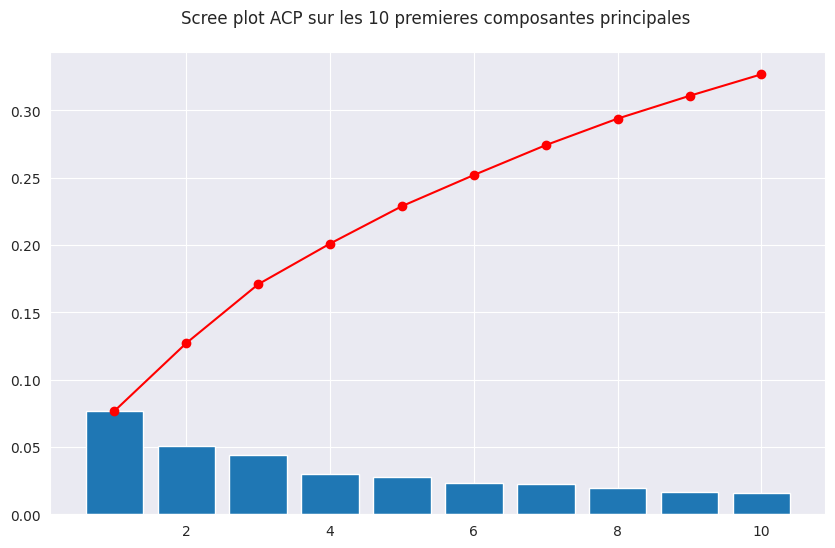

In [29]:
import matplotlib.pyplot as plt
import numpy as np
k=10
# Les valeurs ci-apres ont ete obtenu avec la cellule ci-dessus, lors de l'execution sur AWS.
scree_values = [0.0767, 0.0504, 0.0437, 0.0302, 0.0278, 0.0231, 0.0222, 0.0197, 0.0169, 0.016]

x_list = range(1, k+1)
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree_values)
plt.plot(x_list, np.cumsum(scree_values), color='r', marker='o')
plt.title(f"Scree plot ACP sur les {k} premieres composantes principales \n")
plt.show()

Le coude semble apparaitre à 3 dimensions.

On va donc s'essayer à deux visualisations :
1. Une sur deux dimensions, car c'est simple et visuel
2. Une sur trois dimensions, car cela semble pertinent selon la scree plot ci-dessus.

#### Visualisation dans les espaces vectorielles des PC

On récupère le label, i.e le nom des fruits en photo. On crée aussi "cat_label", le nom plus générique du fruit (e.g on ne distingue pas les différents types de pommes)

In [30]:
df_pca_output['label'] = df_vectorized_images['label']
df_pca_output['cat_label'] = [nom.split(' ')[0] for nom in df_pca_output['label'].values]
df_pca_output.head(4)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893,Pineapple Mini,Pineapple
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585,Pineapple Mini,Pineapple
2,-7.166508,9.220135,-3.933361,-1.749522,3.220139,0.883008,-1.067413,3.023270,5.111882,-7.488251,Cauliflower,Cauliflower
3,-6.648804,8.462039,-4.266296,-1.550884,1.108096,1.917386,0.243583,2.594763,3.594928,-4.829534,Cauliflower,Cauliflower


In [9]:
import seaborn as sns

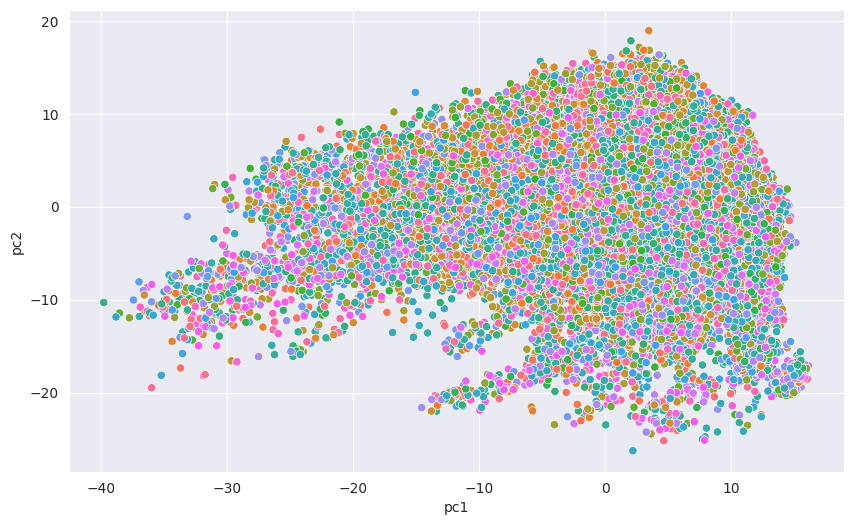

In [10]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='label')
g.legend([],[], frameon=False)
plt.show()

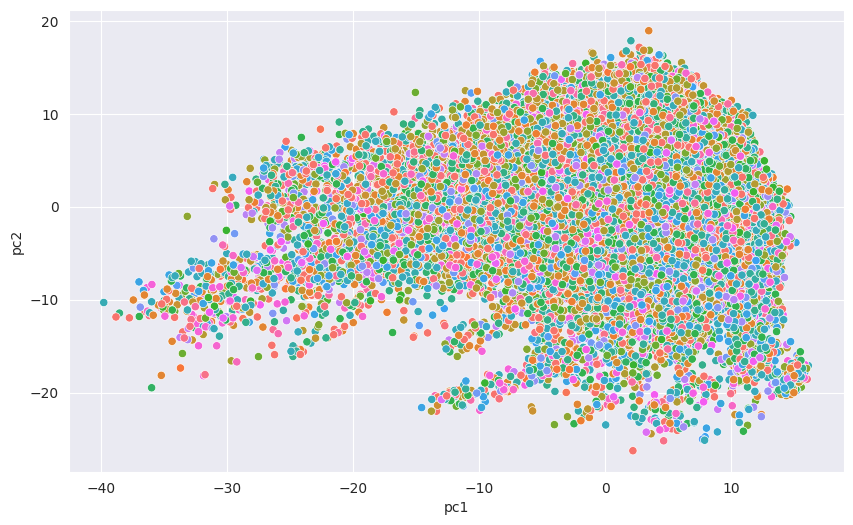

In [11]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='cat_label')
g.legend([],[], frameon=False)
plt.show()

In [12]:
import pandas as pd
df_pca_output.cat_label = pd.Categorical(df_pca_output.cat_label)
df_pca_output['code'] = df_pca_output.cat_label.cat.codes
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label,code
0,-9.920288,3.574020,-5.249853,0.772622,0.280154,10.702513,-5.622513,10.530013,2.705612,-4.760893,Pineapple Mini,Pineapple,50
1,-15.101982,3.067932,-6.347238,-2.776193,1.457287,5.551213,-6.705666,13.987329,0.747148,-5.102585,Pineapple Mini,Pineapple,50


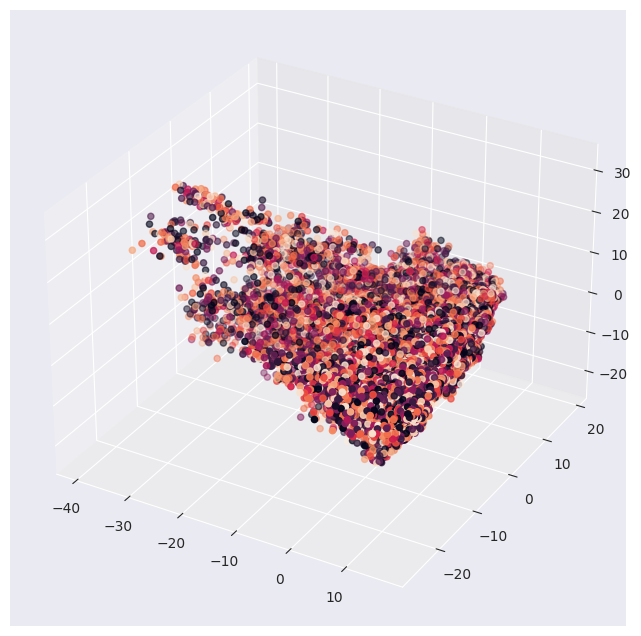

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection='3d')

zdata = df_pca_output['pc3']
xdata = df_pca_output['pc1']
ydata = df_pca_output['pc2']
ax.scatter3D(xdata, ydata, zdata,c=df_pca_output['code']);

plt.show()

Les visualisations ci-dessus ne mettent pas en évidence un découpage particulier. Elles me font me poser question quant à l'intérêt de cette ACP.

Il me manque une visualisation d'ACP : le cercle des corrélations. Mais, les features en entrée de l'ACP étant les poids de l'avant-dernière couche de MobileNetV2, je ne serais pas en mesure d'interpréter vraiment ces résultats. Il faudrait pour cela avoir une compréhension très fine du réseau de neurones convolutifs. Hélas je n'en suis pas encore là, mais peut-être cette connaissance existe-t-elle chez "Fruits", notre start-up de l'agritech :)

# Export pour livrables

In [19]:
PATH = 's3://oc-ds-p8-fruits'
PATH_Result = PATH+'/Results'
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/Results")

In [20]:
df_vectorized_images

,path,label,features
0,s3://oc-ds-p8-fruits/input_pictures/Pineapple ...,Pineapple Mini,"[0.0, 5.0685105, 0.0, 0.0, 0.017583335, 0.0, 0..."
1,s3://oc-ds-p8-fruits/input_pictures/Pineapple ...,Pineapple Mini,"[0.0, 4.803104, 0.021533662, 0.0, 0.0, 0.0, 0...."
2,s3://oc-ds-p8-fruits/input_pictures/Cauliflowe...,Cauliflower,"[0.0, 0.8690344, 1.9584687, 0.0, 0.0, 0.0, 0.0..."
3,s3://oc-ds-p8-fruits/input_pictures/Cauliflowe...,Cauliflower,"[0.050422177, 0.40489227, 1.9727019, 0.0, 0.0,..."
4,s3://oc-ds-p8-fruits/input_pictures/Pineapple/...,Pineapple,"[0.0, 2.9934356, 0.40916774, 0.0, 0.015590305,..."
...,...,...,...
22683,s3://oc-ds-p8-fruits/input_pictures/Banana Red...,Banana Red,"[0.8113197, 0.22021219, 0.036257353, 0.0, 0.10..."
22684,s3://oc-ds-p8-fruits/input_pictures/Banana Red...,Banana Red,"[1.2509062, 0.2784692, 0.041260984, 0.0, 0.304..."
22685,s3://oc-ds-p8-fruits/input_pictures/Banana Lad...,Banana Lady Finger,"[0.067163244, 0.15332088, 0.0, 0.0, 0.28540593..."
22686,s3://oc-ds-p8-fruits/input_pictures/Banana/r_4...,Banana,"[0.029798524, 0.080044195, 0.0, 0.0, 0.4014782..."


In [21]:
# Initialize an empty list to store the numpy arrays
numpy_arrays = [feature for feature in df_vectorized_images['features'].values]
# Create a new DataFrame with the extracted numpy arrays
new_df = pd.DataFrame(numpy_arrays)
new_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.000000,5.068511,0.000000,0.0,0.017583,0.000000,0.332686,0.000000,0.000000,0.0,...,0.000000,0.047895,0.319233,0.096367,0.499471,0.0,0.000000,0.0231,0.055117,0.317730
1,0.000000,4.803104,0.021534,0.0,0.000000,0.000000,0.183534,0.000000,0.000000,0.0,...,0.000000,0.011523,0.063648,0.060213,0.053328,0.0,0.000000,0.0000,0.000000,0.000110
2,0.000000,0.869034,1.958469,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.476193,0.000000,0.195055,0.002832,0.000000,0.0,0.003195,0.0000,0.442363,0.181393
3,0.050422,0.404892,1.972702,0.0,0.000000,0.000000,0.113099,0.163894,0.113727,0.0,...,0.886256,0.000000,0.000000,0.000582,0.436089,0.0,0.006326,0.0000,1.158492,0.043984
4,0.000000,2.993436,0.409168,0.0,0.015590,0.071496,0.012663,0.726258,0.000000,0.0,...,0.000000,0.000000,1.754763,0.151131,0.098372,0.0,0.000000,0.0000,0.277010,0.237618


In [22]:
new_df["label"] = df_vectorized_images["label"]
new_df["path"] = df_vectorized_images["path"]

In [23]:
new_df.to_csv("./livrables/vectorized_imgs.csv", index=False)

In [31]:
df_pca_output.to_csv("./livrables/pca_1_10.csv", index=False)